E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

E02: I was not careful with the intialization of the network in this video.
- What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?
- Can you tune the initialization to get a starting loss that is much more similar to (1)?

E03: Read the Bengio et al 2003 paper, implement and try any idea from the paper. Did it work?

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
g = torch.Generator(device='cpu').manual_seed(2147483647)

In [3]:
words = open('names.txt').read().splitlines()

In [4]:
stoi = {s:i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [5]:
CONTEXT_LEN = 3 # Context length; how many previous characters do we take to predict the next one?

def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * CONTEXT_LEN
        chrs = list(w) + ['.']
        for c in chrs:
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, ytr = build_dataset(words[:n1])
Xv, yv = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])
# Train dataset is used to train the parameters, val is used to tune hyperparameters, and test is used to evaluate the final model.

In [6]:
Xtr.shape # torch.Size([N, CONTEXT_LEN])
ytr.shape # torch.Size([N])

torch.Size([182356])

$$ y_\text{logits} = Wx_\text{cat} + b + U\tanh(Hx_\text{cat} + d) $$
where $ x_\text{cat} $ is `C[X].view(xlen, -1)`

In [7]:
# Initialise/reset parameters

VOCAB_SIZE = 27
EMBED_DIMS = 3
HIDDEN_LAYER_SIZE = 300

xlen = CONTEXT_LEN*EMBED_DIMS # In the paper: (n-1)*m, where n-1 is the context length

C = torch.randn((27, EMBED_DIMS)) # C[5] ≡ F.one_hot(torch.tensor(5), num_classes=27).float() @ C. Former is faster.

H = torch.randn((HIDDEN_LAYER_SIZE, xlen), generator=g)
d = torch.randn((HIDDEN_LAYER_SIZE, 1), generator=g)

U = torch.randn((VOCAB_SIZE, HIDDEN_LAYER_SIZE), generator=g)
W = torch.randn((VOCAB_SIZE, xlen), generator=g)
b = torch.randn((VOCAB_SIZE, 1), generator=g)

params = [C, H, d, U, W, b]
for p in params:
    p.requires_grad = True

In [8]:
cat = C[Xtr].view(xlen, -1)
cat.shape

torch.Size([9, 182356])

In [9]:
sum(p.numel() for p in params) # Total number of parameters

11451

In [10]:
def return_logits(Xb):
    cat = C[Xb].view(xlen, -1)  # Concatenate embeddings: N × (CONTEXT_LEN * EMBED_DIMS)
    logits = W @ cat + b + U @ torch.tanh(H @ cat + d)
    return logits.t()  # Return shape: N × VOCAB_SIZE

In [11]:
# Train
EPOCHS = 10000
BATCH_SIZE = 128

lossi = []
stepi = []

In [12]:
for epoch in range(EPOCHS):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, yb = Xtr[ix], ytr[ix]
    
    # Forward pass
    logits = return_logits(Xb)
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None # Set gradients to zero before backward pass
    loss.backward() # Populate those gradients

    # Update parameters
    with torch.no_grad():
        lr = 0.1 if epoch < EPOCHS/2 else 0.01
        for p in params:
            p.data -= lr * p.grad
    
    # Track stats
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {loss.item()}')
    lossi.append(loss.item())
    stepi.append(epoch * (Xtr.shape[0] // BATCH_SIZE) + ix[0].item() // BATCH_SIZE)

Epoch 0/10000, Loss: 35.2561149597168
Epoch 1000/10000, Loss: 3.1108148097991943
Epoch 2000/10000, Loss: 3.2297511100769043
Epoch 3000/10000, Loss: 3.1440553665161133
Epoch 4000/10000, Loss: 3.4092063903808594
Epoch 5000/10000, Loss: 2.85416579246521
Epoch 6000/10000, Loss: 2.8290605545043945
Epoch 7000/10000, Loss: 2.8746821880340576
Epoch 8000/10000, Loss: 2.8955836296081543
Epoch 9000/10000, Loss: 2.7766354084014893


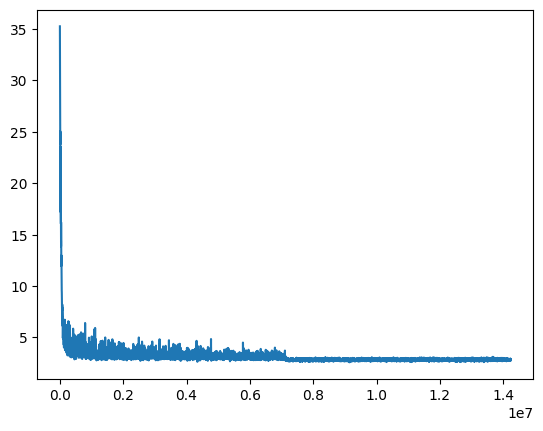

In [13]:
plt.plot(stepi, lossi)

In [14]:
# F.cross_entropy(logits, yb) is the same as:
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# loss = -probs[torch.arange(BATCH_SIZE), yb].log().mean()
# Both will give the same result, but F.cross_entropy is more numerically stable and faster obv

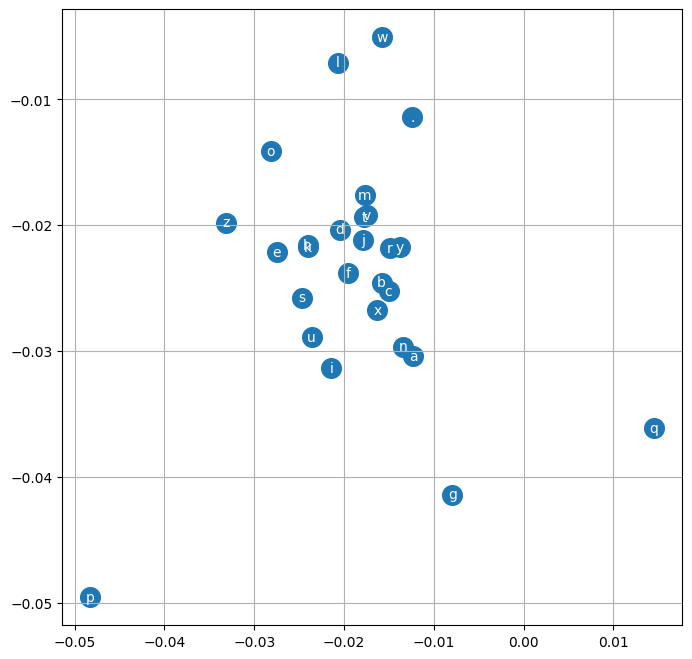

In [15]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [16]:
# Generate names
NUM_NAMES = 10
MAX_LENGTH = 20

names = []

for name in range(NUM_NAMES):
    context = [0] * CONTEXT_LEN  # Start with the context of all dots
    name = []
    
    for _ in range(MAX_LENGTH):
        logits = return_logits(torch.tensor([context], dtype=torch.long))

        probs = F.softmax(logits, dim=-1).squeeze(1)

        next_char_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_char_idx == 0: break # Stop if we hit the end character (dot)
        
        name.append(itos[next_char_idx])
        context = context[1:] + [next_char_idx]  # Update context
    
    names.append(''.join(name))

print(names)

['ailnaybicabeiajgaame', '', 'a', 'r', 'arelnlpnkullvce', 'hvam', 'rclaellinia', 'p', 'srz', 'annacclarcbvyjieskaf']


# 2-layer model

In [17]:
class BengioLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()

        self.linear_path = nn.Linear(input_dim, output_dim)      # Wx + b
        self.tanh_path = nn.Sequential(
            nn.Linear(input_dim, hidden_dims),                   # Hx + d
            nn.Tanh(),                                           # h
            nn.Linear(hidden_dims, output_dim, bias=False)       # U
        )
    def forward(self, x):
        linear_out = self.linear_path(x)
        tanh_out = self.tanh_path(x)
        return linear_out + tanh_out

class BengioModel(nn.Module):
    def __init__(self, vocab_size, embed_dims, context_len, hidden_dims):
        super().__init__()
        self.C = nn.Embedding(vocab_size, embed_dims)

        self.model = nn.Sequential(
            BengioLayer(context_len * embed_dims, hidden_dims[1], hidden_dims[0]),
            BengioLayer(hidden_dims[1], vocab_size, hidden_dims[2]),
        )

    def forward(self, X):
        cat = self.C(X).view(X.shape[0], -1) # Take embeddings and concatenate them
        return self.model(cat)

In [21]:
EPOCHS = 10000
BATCH_SIZE = 256

model = BengioModel(vocab_size=VOCAB_SIZE, embed_dims=10, context_len=CONTEXT_LEN, hidden_dims=[300, 200, 100])

for epoch in range(EPOCHS):
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        lr = 0.1 if epoch < EPOCHS/2 else 0.01
        for p in model.parameters():
            p.data -= lr * p.grad

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {loss.item()}')

Epoch 0/10000, Loss: 3.310124635696411
Epoch 1000/10000, Loss: 2.4600765705108643
Epoch 2000/10000, Loss: 2.3125128746032715
Epoch 3000/10000, Loss: 2.348957061767578
Epoch 4000/10000, Loss: 2.1023201942443848
Epoch 5000/10000, Loss: 2.232112169265747
Epoch 6000/10000, Loss: 2.224982261657715
Epoch 7000/10000, Loss: 2.24953293800354
Epoch 8000/10000, Loss: 2.163243293762207
Epoch 9000/10000, Loss: 2.074795961380005


In [ ]:
@torch.no_grad()
def get_loss(model, X, y):
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    return loss.item()

# Evaluate on validation and test sets
val_loss = get_loss(model, Xv, yv)
test_loss = get_loss(model, Xte, yte)
print(f'Validation Loss: {val_loss}, Test Loss: {test_loss}')

Validation Loss: 2.1842610836029053, Test Loss: 2.1847715377807617


In [20]:
# Generate names
NUM_NAMES = 10
MAX_LENGTH = 20

names = []

for name in range(NUM_NAMES):
    context = [0] * CONTEXT_LEN  # Start with the context of all dots
    name = []
    
    for _ in range(MAX_LENGTH):
        logits = model(torch.tensor([context], dtype=torch.long))

        probs = F.softmax(logits, dim=-1).squeeze(1)

        next_char_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_char_idx == 0: break # Stop if we hit the end character (dot)
        
        name.append(itos[next_char_idx])
        context = context[1:] + [next_char_idx]  # Update context
    
    names.append(''.join(name))

print(names)

['yorahrrirasta', 'napvaydrty', 'porimika', 'shycell', 'ahl', 'slina', 'aryal', 'caumua', 'mize', 'zeluah']
